# Импорты

In [26]:
from os.path import join as pjoin
import tqdm

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
from  torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassPrecision, MulticlassRecall

import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt

# Содержание

- Файл simpson-set.tar.gz: Это набор данных изображений: 20 папок (по одной для каждого персонажа) с 400-2000 изображениями в каждой папке.
- Файл simpson-test-set.zip. : Предварительный просмотр набора данных изображения
- Файл weights.best.h5 : рассчитанные веса для прогнозирования в ядрах.
- Файл annotation.txt: файл аннотации для ограничивающих рамок для каждого символа.

# ----- Программа ------

# Констатанты

In [27]:
# папка откуда берем дата сет
SRC_FOLDER_DATA_SET = "data/simpsons_dataset/"
SRC_FOLDER_DATA_SET_TEST_IMAGE = "data/simpsons_dataset/sideshow_bob\pic_0167.jpg"

# параметры трансформа
MEAN_IMAGE_TRANSFORM = [0.4363, 0.4328, 0.3291]
MEAN_IMAGE_STD = [0.2129, 0.2075, 0.2038]

# классы
CLASSES = ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 
           'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 
           'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 
           'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 
           'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 
           'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']

IS_SHOW_RESULT_TRAIN = 5
IS_SHOW_LOGS = False

In [28]:
# ===================== Конфигурация девайса
# поддержка графического процессора
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Гипер-параметры

In [29]:
EPOCHS = 15
LEARNING_RATE = 0.009
BATCH_SIZE = 128

# Изменение изображения

In [30]:
# ===================== Подготовка изображения
# Обработка входного изображения:
transform_image = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(torch.Tensor(MEAN_IMAGE_TRANSFORM), torch.Tensor(MEAN_IMAGE_STD))
])


# Функции

In [31]:

# считать изображения для дата сета full
def get_full_data_set():
    full_dataset = torchvision.datasets.ImageFolder(root=SRC_FOLDER_DATA_SET, transform=transform_image)
    generator=torch.Generator().manual_seed(42)
    train_dataset, valid_dataset = torch.utils.data.random_split(full_dataset, [0.9, 0.1], generator=generator)
    
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    valid_dataloader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    return train_dataloader, valid_dataloader

# отображение изображений
def print_result_sep_data(data, size):
    plt.figure(figsize=(10, 10))
    for index in range(size):
        plt.subplot(4, 4, index + 1)
        # plt.tight_layout()
        plt.imshow(data[index][0], cmap='gray', interpolation='none')
    plt.show()

# Работа с дата сетом

In [32]:
train_data, test_data = get_full_data_set()
batch, _ = next(iter(train_data))

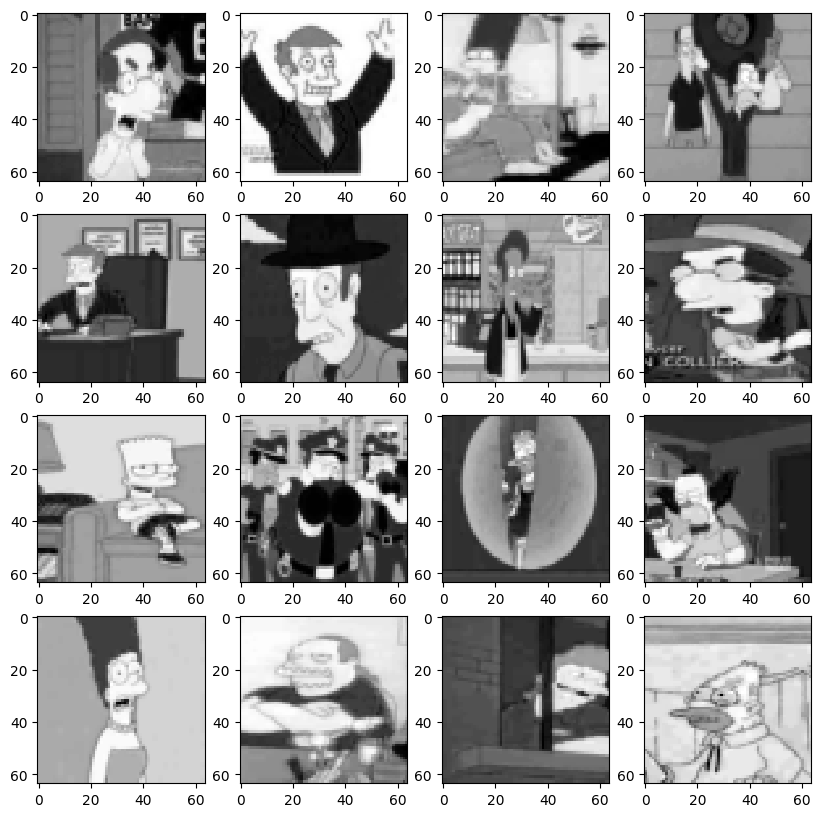

In [33]:
print_result_sep_data(batch, 16) # вывод картинок для себя

In [34]:
# определяем изначальный размер картинки для определения стартового размера слоя
imageTest = batch
print(imageTest.shape)

conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)

x = conv1(imageTest)
print(f'1 {x.shape}')
x = pool(x)
print(f'2 {x.shape}')
x = conv2(x)
print(f'3 {x.shape}')
x = pool(x)
print(f'4 {x.shape}')

# тогда получаем стартовый размер 
start_size_conv = 1024*16*16 #16*13*13
print(f'start_size_conv {start_size_conv}')


torch.Size([128, 3, 64, 64])
1 torch.Size([128, 6, 60, 60])
2 torch.Size([128, 6, 30, 30])
3 torch.Size([128, 16, 26, 26])
4 torch.Size([128, 16, 13, 13])
start_size_conv 262144


# Модель

In [51]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        )

        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.MaxPool2d(2)
        )

        self.res = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(1024*2*2, 1024),
            nn.Linear(1024, len(CLASSES))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.conv3(x)
        x = self.conv4(x)

        x = self.conv5(x)

        x = self.conv7(x)
        x = self.conv8(x) + x

        x = self.conv9(x)
        x = self.res(x)
        return x


# создали модель
model = ConvNet().to(device)

# print(model)
print(torchinfo.summary(model, input_size=(BATCH_SIZE, 3, 64, 64)))


Layer (type:depth-idx)                   Output Shape              Param #
ConvNet                                  [128, 42]                 --
├─Sequential: 1-1                        [128, 64, 64, 64]         --
│    └─Conv2d: 2-1                       [128, 64, 64, 64]         1,792
│    └─BatchNorm2d: 2-2                  [128, 64, 64, 64]         128
│    └─ReLU: 2-3                         [128, 64, 64, 64]         --
├─Sequential: 1-2                        [128, 128, 32, 32]        --
│    └─Conv2d: 2-4                       [128, 128, 64, 64]        73,856
│    └─BatchNorm2d: 2-5                  [128, 128, 64, 64]        256
│    └─ReLU: 2-6                         [128, 128, 64, 64]        --
│    └─MaxPool2d: 2-7                    [128, 128, 32, 32]        --
│    └─Dropout: 2-8                      [128, 128, 32, 32]        --
├─Sequential: 1-3                        [128, 128, 32, 32]        --
│    └─Conv2d: 2-9                       [128, 128, 32, 32]        147,584
│

# Обучение

In [52]:
# создали потери (кроссэнтропия так как у нас много классовая классификация) тут же и совт макс
criterion = nn.CrossEntropyLoss()
# создали оптимизатор стахастический градиентный спуск - получаем скорость обучения
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, 'min')

len_steps = len(train_data)
list_loos = []
# обучение
for epoch in range(EPOCHS):
    list_loos_epoch = []
    # перегрузчик, что бы получить разные партии
    for i, (images, labels) in enumerate(train_data):
        # получаем поддержку графического процессора
        images = images.to(device)
        labels = labels.to(device)
        # проходим вперед
        outputs = model(images)
        # создаем потери
        loss = criterion(outputs, labels)
        list_loos_epoch.append(loss.item())
        # scheduler.step(loss, epoch) # lr <
        # чистка градиента
        optimizer.zero_grad()
        # обратный проход
        loss.backward()
        # оптимизируем шаг
        optimizer.step()
        print(f'Epoch [{epoch+1}/{EPOCHS}], step [{i+1}/{len_steps}], loss {loss.item():.4f}')
    list_loos.append(sum(list_loos_epoch) / float(len(list_loos_epoch)))
print("finish")

Epoch [1/15], step [1/148], loss 4.2860
Epoch [1/15], step [2/148], loss 6.8504
Epoch [1/15], step [3/148], loss 9.7972
Epoch [1/15], step [4/148], loss 10.6327
Epoch [1/15], step [5/148], loss 8.3074
Epoch [1/15], step [6/148], loss 9.7600
Epoch [1/15], step [7/148], loss 7.5404
Epoch [1/15], step [8/148], loss 6.9326
Epoch [1/15], step [9/148], loss 4.8879
Epoch [1/15], step [10/148], loss 4.5051
Epoch [1/15], step [11/148], loss 4.9258
Epoch [1/15], step [12/148], loss 4.3391
Epoch [1/15], step [13/148], loss 4.0106
Epoch [1/15], step [14/148], loss 3.8740
Epoch [1/15], step [15/148], loss 3.7644
Epoch [1/15], step [16/148], loss 3.8316
Epoch [1/15], step [17/148], loss 3.3314
Epoch [1/15], step [18/148], loss 3.3886
Epoch [1/15], step [19/148], loss 3.4849
Epoch [1/15], step [20/148], loss 3.5710
Epoch [1/15], step [21/148], loss 3.2213
Epoch [1/15], step [22/148], loss 3.2507
Epoch [1/15], step [23/148], loss 3.4716
Epoch [1/15], step [24/148], loss 2.9922
Epoch [1/15], step [25/1

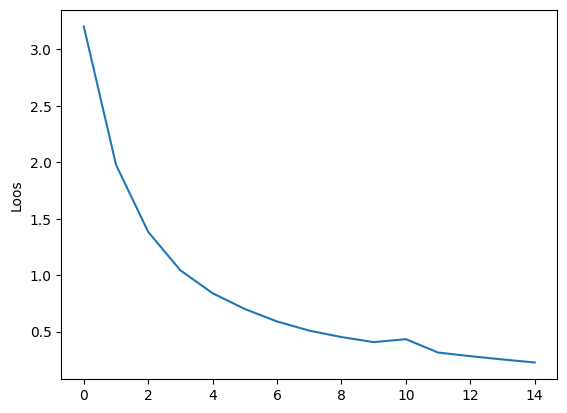

In [53]:
plt.plot([i for i in range(0, EPOCHS)], list_loos)
plt.ylabel('Loos')
plt.show()

# Проверка точности

In [54]:
classes = CLASSES
classes_amount = len(CLASSES)

recall = MulticlassRecall(num_classes=classes_amount, average=None)
precision = MulticlassPrecision(num_classes=classes_amount, average=None)
f1 = MulticlassF1Score(num_classes=classes_amount)
recall.to(device)
precision.to(device)
# f1.to(device)

with torch.no_grad():
    model.eval()
    for images, labels in test_data:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        recall.update(outputs, labels)
        precision.update(outputs, labels)
        # f1.update(outputs, labels)
# tp, fp, tn, fn = precision._final_state()

recall_class = {classname: val.item()
                for classname, val in zip(classes, recall.compute())}
precision_class = {classname: val.item()
                   for classname, val in zip(classes, precision.compute())}
# f1_class = {classname: val.item()
#             for classname, val in zip(classes, f1.compute())}

total_rec = sum(recall.compute())/classes_amount
total_prec = sum(precision.compute())/classes_amount


# График Метрик

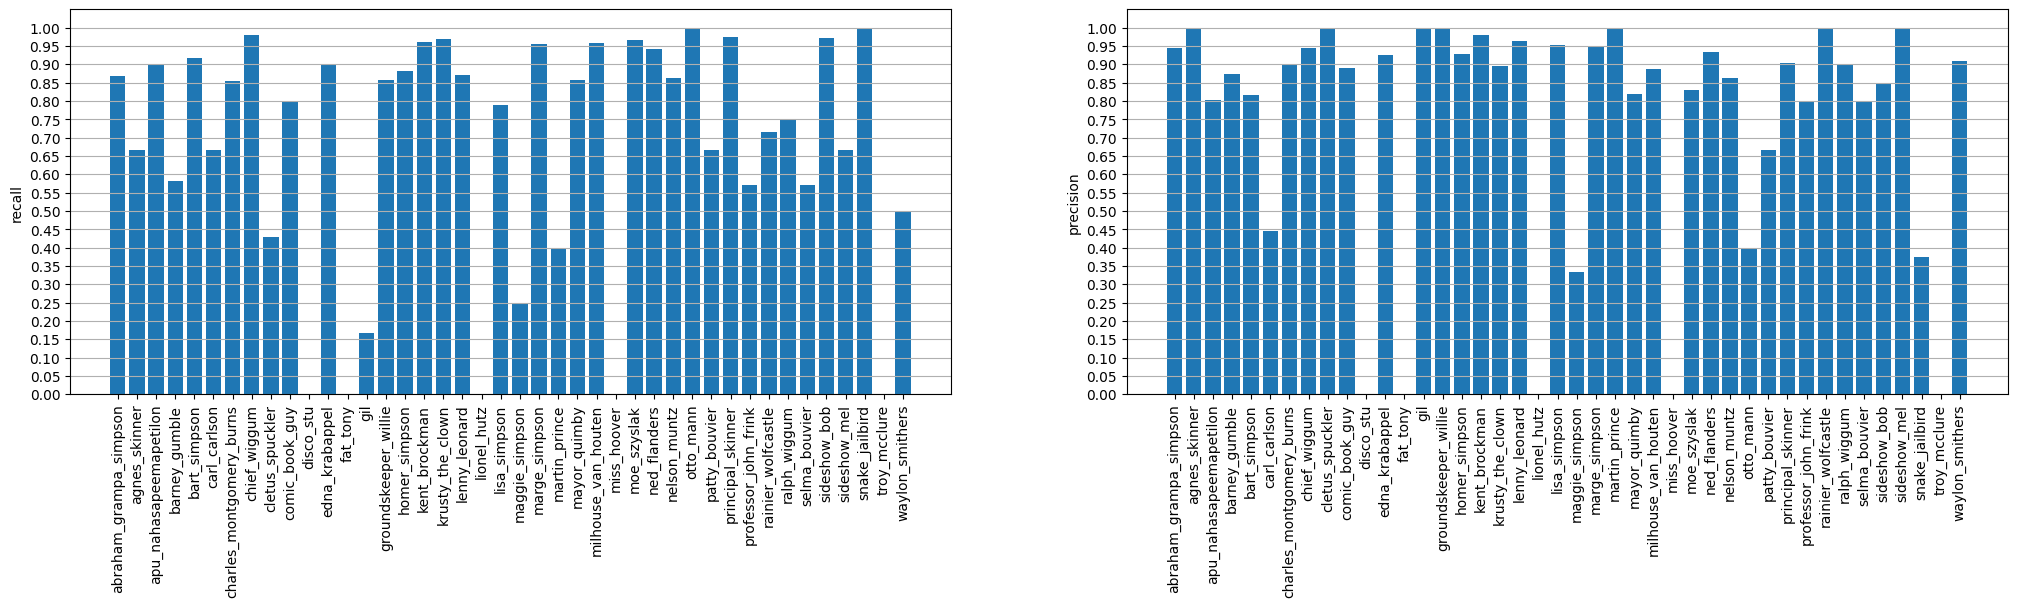

 total_rec: 0.68%
 total_prec: 0.75%


In [55]:
metrics_per_class = {
    "recall": recall_class, "precision": precision_class}

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
for (metricName, mVal), ax in zip(metrics_per_class.items(), axes):
    plt.sca(ax)
    plt.bar(mVal.keys(), mVal.values())
    plt.ylabel(metricName)
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.yticks(ticks=np.arange(0, 1.01, 0.05))
plt.show()

print(
    f' total_rec: {total_rec:.2f}%\n total_prec: {total_prec:.2f}%')


# Мои наработки разные в общем мусор

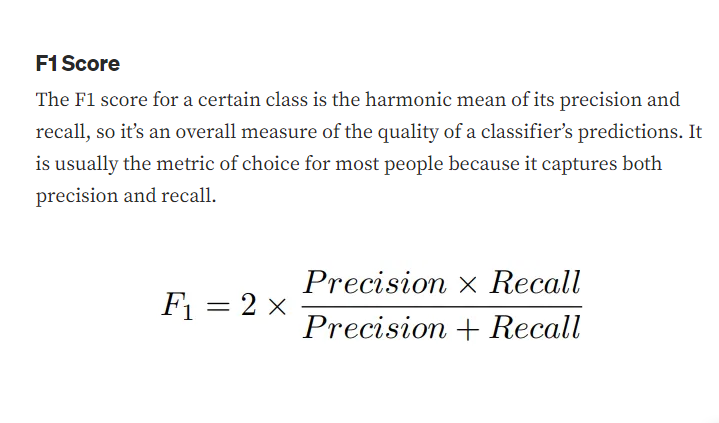

In [56]:

# accur = (tp+tn)/(tp+tn+fp+fn)
# total_accur = sum(accur)/classes_amount

# Они смягчают проблему исчезновения градиента, позволяя этому альтернативному короткому пути проходить градиент
# Они позволяют модели изучать функцию идентичности, которая гарантирует, что верхний уровень будет работать по меньшей мере так же хорошо, как и нижний, и не хуже

# # вычисление точности всей сети
# list_acc = []

# with torch.no_grad():
#     n_correct = 0
#     n_samples = 0
#     n_class__correct = [0 for i in range(len(CLASSES))]
#     n_class__samples = [0 for i in range(len(CLASSES))]

#     for images, labels in test_data:
#         images = images.to(device)
#         labels = labels.to(device)

#         outputs = model(images)

#         # максимальное значение индекс
#         _, predicted = torch.max(outputs, 1)
#         n_samples += labels.size(0)
#         n_correct += (predicted == labels).sum().item()

#         for i in range(len(labels)):
#             label = labels[i]
#             pred = predicted[i]
#             if (label == pred):
#                 n_class__correct[label] += 1
#             n_class__samples[label] += 1

#     acc = 100 * n_correct / n_samples
#     print(f'Accuracy of the network {acc} %\n\n')

#     # вычисление точности для классов
#     for i in range(len(CLASSES)):
#         if (n_class__correct[i] != 0):
#             acc = 100 * n_class__correct[i] / n_class__samples[i]
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         else:
#             acc = 0
#             print(f'Accuracy of {CLASSES[i]} {acc} %')
#         list_acc.append(acc)


In [57]:
# fig = plt.figure(figsize=(16, 8))

# plt.bar(CLASSES, list_acc)
# plt.grid()
# plt.xticks(rotation=45, ha='right')
# plt.show()

In [58]:
    #     self.conv1 = nn.Sequential(
    #         nn.Conv2d(3, 64, 5),
    #         nn.BatchNorm2d(64),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv2 = nn.Sequential(
    #         nn.Conv2d(64, 32, 5),
    #         nn.BatchNorm2d(32),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.conv3 = nn.Sequential(
    #         nn.Conv2d(32, 16, 5),
    #         nn.BatchNorm2d(16),
    #         nn.ReLU(True),
    #         nn.MaxPool2d(2,2),
    #         nn.Dropout(0.2),
    #     )
        
    #     self.fc1 = nn.Linear(start_size_conv, 512)
    #     self.fc2 = nn.Linear(512, 128)
    #     self.fc3 = nn.Linear(128, 64)
    #     self.fc4 = nn.Linear(64, len(CLASSES))
        
    # def forward(self, x: torch.Tensor):
    #     x = self.conv1(x)
    #     x = self.conv2(x)
    #     x = self.conv3(x)
        
    #     x = x.view(-1, start_size_conv) # сплющели
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))
    #     x = self.fc4(x)
    #     return x
    
    # 50 gпроцентов без 3го, за 10 итераций, за 10 с двумя